Check isostable elimination is accurate

# CGL 2

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
#import cgl_thalamic as ct
import cgl2 as ct

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

reload(ct)
reload(nm)
reload(rp)

nmc = nm.nmCoupling
rsp = rp.Response

In [2]:
pd1 = {'q':1,'d':.9,'sig':.1,'rho':.15,'mu':.15,
       'om':1,'om_fix':1,'alc':3,'bec':2,'esyn':0}

system1 = rsp(var_names=['x','y','w'],
              pardict=pd1,rhs=ct.rhs_cgl,
              init=np.array([.333,0,0,2*np.pi]),
              TN=2000,
              idx=0,
              model_name='cgl0',
              
              recompute_list=[],
              z_forward=False,
              i_forward=False,
              i_bad_dx=False,
              coupling=ct.coupling_cgl)

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.029999999999955514
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [3]:
pd2 = {'q':1,'d':.9,'sig':.1,'rho':.15,'mu':.15,
       'om':1,'om_fix':1,'alc':3,'bec':2,'esyn':0}

system2 = rsp(var_names=['x','y','w'],
              pardict=pd2,rhs=ct.rhs_cgl,
              init=np.array([.333,0,0,2*np.pi]),
              TN=2000,
              idx=1,
              model_name='cgl1',
              
              recompute_list=[],
              z_forward=False,
              i_forward=False,
              i_bad_dx=False,
              coupling=ct.coupling_cgl)

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.029999999999955514
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [4]:
a = nm.nmCoupling(system1,system2,
                  #recompute_list=[],
                  #recompute_list=['p_cgl0','p_cgl1'],
                  recompute_list=['p_data_cgl0','p_data_cgl1'],
                  #recompute_list=recompute_list,
                  _n=('om0',1),_m=('om1',2))

## system 1

In [5]:
rule = {**system1.rule_p,**system2.rule_p,
        **system1.rule_par,**system2.rule_par,
        **system1.rule_lc,**system2.rule_lc,
        **system1.rule_i,**system2.rule_i,
        **system1.rule_g,**system2.rule_g}

In [6]:
print(system1.p['sym'][1].subs(rule))

-ix0_0(th0)*w1(th1)*x0(th0)


In [7]:
# collect forcing function for each order
p_het_lam = []
for i in range(system1.miter):
    p_het_lam.append(sym.lambdify(a.ths,system1.p['sym'][i].subs(rule)))

In [8]:
# check forcing function works
p_het_lam[2](1,1)

-1.9284464827861427

In [9]:
om = a._n[1]/a._m[1]

### order 1

In [10]:
from lib.fast_interp import interp2d # remove endpoint when working with fast_interp
from sympy.utilities.lambdify import lambdify, implemented_function
imp_fn = implemented_function

p brute (for testing)

In [11]:
NA = 50;NB = 51
k = 1

x1,dx1 = np.linspace(0,2*np.pi,NA,retstep=True,endpoint=False)
x2,dx2 = np.linspace(0,2*np.pi,NB,retstep=True,endpoint=False)

het1 = np.zeros((NA,NB))
s = np.arange(0,a.T*a.pfactor,dx1)

for i in range(NA):
    for j in range(NB):
        f1 = p_het_lam[1](x1[i]-om*s,x2[j]-s)
        het1[i,j] = np.sum(f1*np.exp(om*s*system1.kappa_val))
        
het1 *= om*dx1

In [12]:
p_int1b = interp2d([0,0],[2*np.pi,2*np.pi],[dx1,dx2],het1,k=3,p=[True,True])
p_imp1b = imp_fn('px_test1b',a.fast_interp_lam(p_int1b))
p_lam1b = lambdify(a.ths,p_imp1b(a.ths[0],a.ths[1]))

p conv

In [13]:
NP = 150
p_data1 = np.zeros((NP,NP))
r,dr = np.linspace(0,2*np.pi,NP,retstep=True,endpoint=False)
s1 = np.arange(0,a.T*a.pfactor,dr)
#print(s1[-1],a.T*a.pfactor,dr)

exponential = np.exp(om*s1*system1.kappa_val)
g_in = np.fft.fft(exponential)
a_i = np.arange(NP,dtype=int)

for ll in range(len(r)):
    f_in = np.fft.fft(p_het_lam[1](r[ll]+om*s1,s1))
    conv = np.fft.ifft(f_in*g_in)
    p_data1[(a_i+ll)%NP,a_i] = conv[-NP:].real
    
p_data1 *= om*dr

In [14]:
p_int1c0 = interp2d([0,0],[2*np.pi,2*np.pi],[dr,dr],p_data1,k=3,p=[True,True])
X,Y = np.meshgrid(a.an,a.an,indexing='ij')
p_data1_fixed = p_int1c0(X+Y*a.om,Y)
p_int1c = interp2d([0,0],[2*np.pi,2*np.pi],[a.dan,a.dan],p_data1_fixed,k=3,p=[True,True])
p_imp1c = imp_fn('px_test1c',a.fast_interp_lam(p_data1_fixed))
p_lam1c = lambdify(a.ths,p_imp1c(a.ths[0],a.ths[1]))

Plot slices

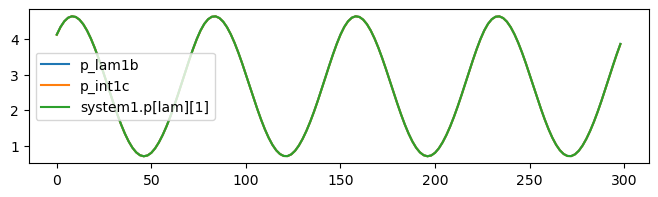

In [15]:
# convolve jupyter vs brute jupyter vs brute nmcoupling

# ll = 0;f1 = lam1(r[ll]+om2*s1,s1)
# fa = np.fft.fft(f1)
# conv = np.fft.ifft(fa*fb)*om*dr

thatY = 1
fac = 4

fig,axs = plt.subplots(figsize=(8,2))
axs.plot(np.arange(2*NP)[::2],p_lam1b(r[ll]+fac*r,fac*r+thatY),label='p_lam1b')
#axs.plot(conv.real[-2*NP:],label='conv.real[-2*NP:]')
#axs.plot(p_data1[(a_i+ll)%NP,a_i],label='p_data1[(a_i+ll)%NP,a_i]')
axs.plot(np.arange(2*NP)[::2],p_int1c(fac*r+r[ll],fac*r+thatY),label='p_int1c')
axs.plot(np.arange(2*NP)[::2],system1.p['lam'][1](fac*r+r[ll],fac*r+thatY),label='system1.p[lam][1]')
#axs.set_xlim(len(s1)-NP,len(s1))
axs.legend()

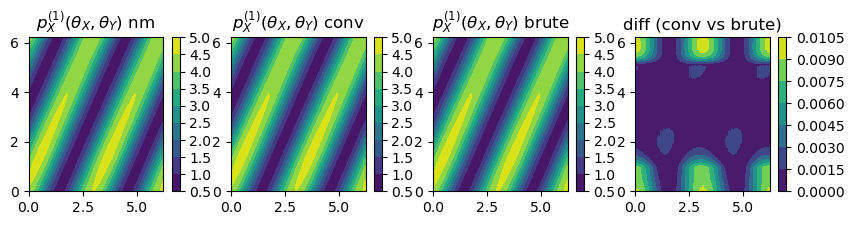

In [16]:
fig,axs = plt.subplots(1,4,figsize=(10,2))
lamout_conv = p_int1c(X,Y)
lamout_brut = p_lam1b(X,Y)
lamout_nmco = system1.p['lam'][1](X,Y)
im0 = axs[0].contourf(X,Y,lamout_nmco)
im1 = axs[1].contourf(X,Y,lamout_conv)
im2 = axs[2].contourf(X,Y,lamout_brut)
im3 = axs[3].contourf(X,Y,np.abs(lamout_conv - lamout_brut))

axs[0].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ nm')
axs[1].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ conv')
axs[2].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ brute')
axs[3].set_title(r'diff (conv vs brute)')

plt.colorbar(im0,ax=axs[0])
plt.colorbar(im1,ax=axs[1])
plt.colorbar(im2,ax=axs[2])
plt.colorbar(im3,ax=axs[3])

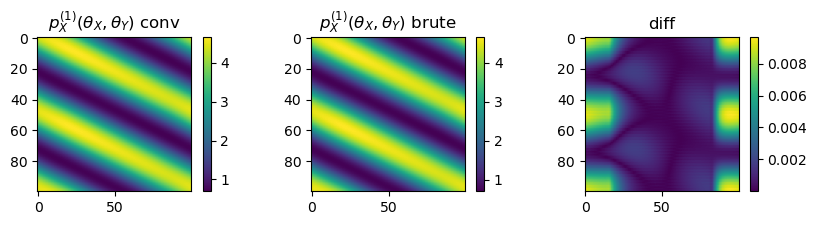

In [17]:
fig,axs = plt.subplots(1,3,figsize=(10,2))
im0 = axs[0].imshow(lamout_conv)
im1 = axs[1].imshow(lamout_brut)
im2 = axs[2].imshow(np.abs(lamout_conv - lamout_brut))

axs[0].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ conv')
axs[1].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ brute')
axs[2].set_title(r'diff')

plt.colorbar(im0,ax=axs[0])
plt.colorbar(im1,ax=axs[1])
plt.colorbar(im2,ax=axs[2])

In [18]:
(system1.K['sym']['x0'][0]).subs(rule)

-w1(th1)*x0(th0)

In [19]:
K_lam = sym.lambdify(a.ths,system1.K['sym']['x0'][0].subs(rule))
K_lam(1,2)*system1.i['lam_x0'][0](1)

0.016843322502671742

In [20]:
# ### plot het. terms for p. direct vs precalculated.
# fig,axs = plt.subplots(figsize=(8,2))
# ttemp = np.linspace(0,4*np.pi,100)
# th0 = 1;th1 = 2
# axs.plot(system1.i['lam_x0'][0](th0+ttemp*om)*K_lam(th0+ttemp*om,th1+ttemp)) # directly calcualted het. term
# axs.plot(p_het_lam[1](th0+ttemp*om,th1+ttemp)) # pre-calculated symbolic het. term
# axs.set_title('plot het. terms for p. direct vs precalculated.')

### Integerate ODE and brute

In [21]:
def px1(t,p,thatX,thatY):
    dp = system1.kappa_val*p + p_het_lam[1](thatX+om*t,thatY+t)
    return dp*om

In [22]:
thatX = 1;thatY = 5

In [23]:
t = np.arange(0,100*2*np.pi,.01)
sol = solve_ivp(px1,[0,t[-1]],[4.4],args=(thatX,thatY),t_eval=t,method='LSODA',atol=1e-7,rtol=1e-7)

In [25]:
skipn = 100
sol_brute = np.zeros(len(t[::skipn]))

for i in range(len(t[::skipn])):
    s = np.arange(0,t[::skipn][i],a.dan)
    f1 = p_het_lam[1](thatX+om*s,thatY+s)
    sol_brute[i] = om*np.sum(f1*np.exp(om*(t[::skipn][i]-s)*system1.kappa_val))*a.dan

### $p_X^{(1)}(\hat\theta_X+\omega s,\hat\theta_Y+s)$ versus $p_X^{(1)}(s)$

Compare brute integration, ODE integration, and convolution. All should be equivalent. All methods require integrating over long enough times, the convolution is the most efficient.

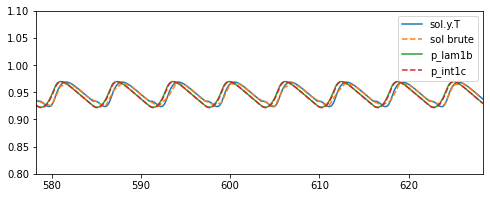

In [31]:
# plot solution
startn = 30000
fig,axs = plt.subplots(figsize=(8,3))
axs.plot(t,sol.y.T,label='sol.y.T')
axs.plot(t[::skipn],sol_brute,label='sol brute',ls='--')
axs.plot(t,p_lam1b(thatX+t-(thatY+t)*om,thatY+t)/(1.02*np.pi),label='p_lam1b')
axs.plot(t,p_int1c(thatX+t-(thatY+t)*om,thatY+t)/(1.02*np.pi),label='p_int1c',ls='--')
#axs.plot(t,system1.p['lam'][1](thatX+t,thatY+t),label='plam',alpha=.4)
axs.set_xlim(t[-1]-50,t[-1])
axs.set_ylim(.8,1.1)
axs.legend()

In [32]:
sol.y.T[-1]

array([0.93760956])

In [33]:
system1.p['lam'][1](np.array([thatX]),np.array([thatY]))

array([0.93722338])